# ECON622: Computational Economics with Data Science Applications

Rethinking Least Squares

Jesse Perla (University of British Columbia)

# Overview

## Motivation

-   In preparation for the ML lectures we cover some core numerical
    linear algebra concepts on functional equations
-   We will also use this as an opportunity to reinterpret least squares
    solutions as a prelude to non-linearity

## Packages and Materials

-   See [QuantEcon Numerical Linear
    Algebra](https://julia.quantecon.org/tools_and_techniques/numerical_linear_algebra.html)
    and associated notebooks

In [1]:
using LinearAlgebra, Statistics, BenchmarkTools, SparseArrays, Random
using Plots
Random.seed!(42);  # seed random numbers for reproducibility

# Least Squares with the QR Decomposition

## QR Decomposition

-   QR is for general rectangular matrices $A = Q R$ for $Q$ orthogonal
    and $R$ upper triangular
-   Especially useful for least-squares problems, where it is fast and
    numerically stable.

$$
\min_x \| Ax -b \|^2
$$

-   Normal equations are $x = (A'A)^{-1}A'b$

-   Given a QR Decomposition $R x = Q' b$

    -   Where we recall that for upper-triangular $R$ the system of
        equations is easy to solve

## QR is Used Internally for Least Squares

-   Inside of the `\` it will do a QR
-   See full lectures for implementing the `qr(A) \ b`

In [2]:
N = 10
M = 3
x_true = rand(3)

A = rand(N, M) .+ randn(N)
b = rand(N)
x = A \ b
@show qr(A) \ b;

qr(A) \ b = [0.20546505358047384, -0.1735596121696614, 0.26558938619229516]

## QR and Underdetermined Least Squares

-   Take the case where $N < M$ and use the QR decomposition.

In [3]:
A = [1.0 2.0 3.0;
     4.0 5.0 6.0]
b = [7.0, 8.0]
@show A \ b;

A \ b = [-3.0555555555555522, 0.11111111111111072, 3.277777777777776]

-   Wait, why did that give an answer?
    -   And if I try various algorithms even with random starting
        points, why does it give the same answer?
    -   There is a bias towards a particular solution. Will come back to
        this repeatedly

# Min-Norm Solutions and Sobolev Spaces

## Min-Norm Solution

-   Linear least squares was solving $\min_x \| Ax -b \|_2^2$

-   Which had multiplicity in this case. The solution it returns
    fulfills

$$
\min_x \| x \|_2^2 \quad \text{s.t.} Ax = b
$$

-   Or, can think of as solving the “ridgeless regression”

$$
\lim_{\lambda \to 0}\left[\min_x \| Ax -b \|_2^2 + \lambda \| x \|_2^2\right]
$$

-   Will become crucial in deep learning where the number of parameters
    $\gg$ data

## Algorithms + Optimization Problems

-   A key requirement to make the switch to ML thinking is to remember
    that just seeing the optimization problem, e.g. $\max_{x} f(x)$ may
    not be enough
-   The algorithm itself will be important if there is there is
    multiplicity in solutions, if things are not numerically stable,
    etc.
-   In the case above, we saw that using QR decomposition delivered the
    min norm

## Linear Operators, not Matrices

-   Recall: for $x \in \mathbb{R}^N$ we should think of a $f(x) = A x$
    for $A\in\mathbb{R}^{M \times N}$ as a linear transformation from
    $\mathbb{R}^N$ to $\mathbb{R}^M$
    -   Definition of Linear: $f(a x_1 + b x_2) = a f(x_1) + b f(x_2)$
        for scalar $a,b$
-   Many algorithms might be implementable just using the matrix-vector
    product or the transpose of the matrix-vector product?
-   Maybe we don’t actually need to create a matrix? Can compose
    operations together?
-   This will be related to a lot of ML algorithms and
    autodifferentiation. Hint: Jacobian $\nabla f(x) = A$
-   The key to iterative methods will be the spectral properties of the
    Jacobian, which is related to the eigenvalues of $A$

## $L^p$ space

Let $\Omega$ be an open subset of $\mathbb{R}^n$. A function
$u: \Omega \rightarrow \mathbb{R}$

**$L^p(\Omega)$ space**: A function $f: \Omega \rightarrow \mathbb{R}$
is in $L^p(\Omega)$ if:

$$
\int_\Omega |f|^p \, dx < \infty
$$

-   Useful in a lot of cases, but will be especially important when
    considering norms on a function space and whether a particular
    function solves a particular problem

## Sobolev Space

A function $u$ belongs to the **Sobolev space** $W^{k,p}(\Omega)$ if:

$$
u \in L^p(\Omega)
$$

and all its weak derivatives up to order $k$ are also in $L^p(\Omega)$.

A function $\phi \in W^{k,p}(\Omega)$ is said to be a **weak
derivative** of $u$ if:

$$
\int_\Omega u D^\alpha \phi \, dx = (-1)^{|\alpha|} \int_\Omega \phi D^\alpha u \, dx
$$

for all multi-indices $\alpha$ with $|\alpha| \leq k$.

## Sobolev Norm

The **Sobolev Norm** for a function $u \in W^{k,p}(\Omega)$ is defined
as some variation on:

$$
\| u \|_{W^{k,p}(\Omega)} = \left( \sum_{|\alpha| \leq k} \int_\Omega |D^\alpha u|^p \, dx \right)^{1/p}
$$

where $\alpha$ is a multi-index and $D^\alpha u$ represents the weak
derivative of $u$.

You can choose whatever terms you want in $\alpha$

## A Key Sobolev Semi-Norm

The key one to keep in mind is $W^{1,2}(\Omega)$, which is the space of
functions with square-integrable first derivatives.

$$
\| u \|_{W^{1,2}(\Omega)} = \left( \int_\Omega |\nabla u|^2 \, dx \right)^{1/2}
$$

-   Note that we have the option to include or not include the $|u|^2$
    term itself when we define a particular norm
-   This is a semi-norm because it is semi-definite (i.e., multiple $u$
    with $\|u\| = 0$)
-   Semi-norms serve two key purposes: establish equivalence classes,
    and prove a way to control length which will come up with algorithms

## Sobolev Semi-Norms and Equivalence Classes

-   A Sobolev semi-norms $S$ define equivalence classes of functions
    -   i.e., any $u_1$ and $u_2$ such that $\|u_1 - u_2\|_S = 0$ are in
        the same equivalence class
-   In general, when we move to nonlinear and highly parameterized
    models there will be many solutions that are equivalent
    -   But if they are in approximately the same equivalence class,
        then who cares?
    -   Multiplicity of “parameters” doesn’t really matter if the
        functions do the same thing

## Sobolev Semi-Norms and Occam’s Razor

-   The other purpose is to give some sense of length,
    $\|u_1\|_S < \|u_2\|_S$
-   This will come up with regularization since we may want to bias
    algorithms towards particular functions or interpret inherent bias
    in the algorithms
-   The key interpretation here is that for Sobolev Norms we can think
    of variations on the $W^{1,2}$ as determining how simple a function
    is
    -   If $\|u_1\|_S < \|u_2\|_S$ then it has smaller gradients and
        fewer “wiggles”
    -   If both interpolate the same data, then we should prefer the
        simpler one. Occam’s Razor
-   We won’t always be able to know the precise semi-norm when working
    with ML, but this is useful intuition

## Sobolev Norms and Linear Functions

-   Now, think of linear functions $f(x) = \beta x$ where $\beta$ is a
    vector, matrix, or scalar
    -   Consider this on a bounded domain $\Omega$ so the integrals are
        well defined
-   Then our Sobolev 1,2 norm, $W^{k,p}$ here is simple:

$$
\|f\|_{W^{1,2}} = \|\beta\|_2
$$ Where $\|\beta\|_2$ is euclidean norm of the vector, or the Frobenius
norm of the matrix

## Back to the Ridgeless Regression

Now lets reinterpret our “ridgeless regression” with a

$$
\lim_{\lambda \to 0}\left[\min_{\beta} \| A\beta -b \|_2^2 + \lambda \| \beta \|_2^2\right]
$$

-   This says that we are “penalizing” the norm of $f(x) = \beta x$ in
    the $W^{1,2}$ sense
-   The limit $\lambda \to 0$ means we are asymptotically dropping this
    penalty, but there is still this “bias” which makes solutions unique
-   Normally unique to an equivalence class with in $W^{1,2}$, but with
    linear functions they are unique. Why?

## Min-Norm Solution as Occam’s Razor

Recall that this was also

$$
\min_{\beta} \| \beta \|_2^2 \quad \text{s.t.}\, A\beta = b
$$

-   i.e., we are finding the minimum norm solution that interpolates our
    data
-   And we can interpret the minimum norm through Occam’s Razor
-   This general principle will apply when we think about nonlinear
    approximations as well, though we don’t need to fully interpolate
    (i.e., if $\lambda > 0$ then we don’t need to interpolate perfectly)
-   Suggests the crucial role of regularization. Discuss!

## Singular Linear Systems of Equations

This isn’t just least squares

-   Consider the case for finding solutions to $A \beta = b$ where $A$
    is singular. Either no solution or infinite solutions exist
-   If you solve a linear system with SVD or iterative methods it gives
    an answer! The min-norm solution

$$
\begin{aligned}
\min_{\beta} & \| \beta \|_2^2\\
&\text{s.t.} A\beta = b
\end{aligned}
$$

## Is the Min-Norm Solution Special?

-   The min-norm solution to LLS/etc. is the closest projection to the
    column space of the data

-   For a given norm it is the unique solution to a well-specified
    problem which can often be interpreted through appealing to
    simplicity

-   It is also the unique “most stable” solution for a given norm.
    Loosely,

    -   Take $b + \delta b$ for some small $\delta b$ and/or
        $A + \delta A$ for some small $\delta A$
    -   Then the min-norm solution is the one where
        $\beta + \delta \beta$ is smallest

-   Another interpretation we will apply to ML and nonlinear models:
    min-norm solutions are the ones least sensitive to data
    perturbations

-   This will also come up with Bayesian statistics, if we apply a prior
    which is asymptotically non-informative, the min-norm solution is
    the MAP solution

## Min-Norm Solution and Conditioning

-   As a preview of the next lecture, consider if the matrix is almost,
    but not quite singular
    -   Tough to know due to numerical roundoff
-   You may have learned from experience that everything works great if
    you:
    -   Tweak to the diagonal of the matrix, or to the normal equations
        for LLS, or to make a covariance matrix positive definite
-   Consider how that is related to the min-norm solution and L2
    penalized LLS (i.e., “ridge”)
    -   Will turn out to be exactly equivalent in many algorithms

# Geometry and Loss Functions

## Geometry of Loss Functions

-   The curvature of the less function will be essential to
    understanding generalization
    -   The motivation: we will work with models where every local
        minima is a global minima, multiplicity is pervasive but
        innocuous, etc.
-   For some $\beta^*$ which is a local minima of
    $\min_{\beta} f(X;\beta)$ the Hessian $\nabla^2 f(X;\beta^*)$ tells
    us about whether minima are unique, how sensitive they are to
    perturbations, etc.
-   Key questions to ask:
    -   What is the rank of the hessian? If full rank, with a positive
        definite hessian, then the solution is (locally) unique
    -   Eigenvalues show ridges/etc.

## Geometry of Regularized LLS

$$
\min_{\beta} \underbrace{\frac{1}{2}\left[\| X\beta -y \|_2^2 + \lambda \| \beta \|_2^2\right]}_{\equiv f(X;\beta)}
$$

-   The Hessian is then (for all $\beta$)

$$
\nabla^2 f(X;\beta^*) = X^{\top} X + \lambda I
$$

-   Is this problem convex with $\lambda = 0$? Only if $X^{\top}X$ is
    positive definite

## Reminder on Positive and Semi-Definite

-   **Positive definite** if $x^{\top} A x > 0,$ (“semi-definite” if
    $\geq 0$) for all $x \neq 0$

-   With the spectral decomposition of symmetric $A$

    $$
    A = Q \Lambda Q^{\top}
    $$

    -   $\Lambda = \text{diag}(\lambda_1, \ldots, \lambda_n)$ and $Q$ is
        an orthogonal matrix of eigenvectors
    -   $A$ is positive definite if $\lambda_i > 0$ for all $i$
    -   $A$ is positive semi-definite if $\lambda_i \geq 0$ for all $i$

-   In more abstract and infinite dimensional spaces a linear operator
    $A(x)$ operator is positive definite if $x \cdot A(x) > 0$ for all
    $x \neq 0$

    -   Has eigenvalues/eigenvectors, i.e. $A(x) = \lambda x$ for some
        $\lambda$ and $x$

## Convexity of a Quadratic Objective

-   We will build $P$ and $f(x) = \frac{1}{2}x^{\top} P x$ from the
    spectral decomposition
-   Rotating eigenvectors and starting with
    $\Lambda = \text{diag}(1, 1)$
-   And keep in mind that $\nabla f(x) = P x$

In [4]:
Q = [sqrt(2)/2 sqrt(2)/2;
    -sqrt(2)/2 sqrt(2)/2]
Lambda = [1.0, 1.0]
P = Q * Diagonal(Lambda) * Q' # since symmetric
P

2×2 Matrix{Float64}:
 1.0  0.0
 0.0  1.0

## Contours of the Quadratic Objective


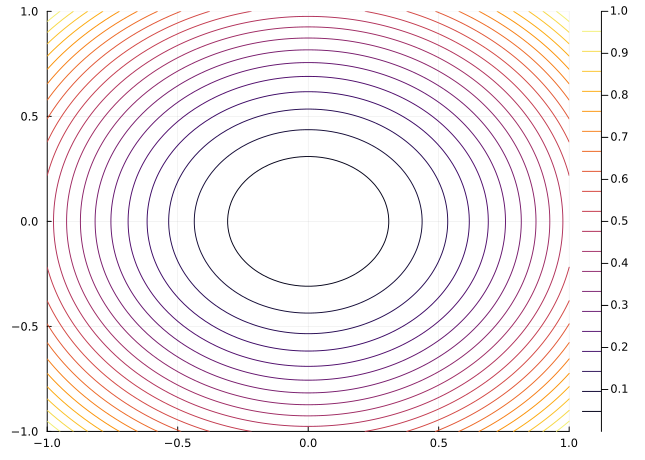

In [5]:
x_vals = range(-1, 1, length = 100)
f(x1, x2) = 0.5 * [x1, x2]' * P * [x1, x2]
contour(x_vals, x_vals, f, levels = 20, legend = true)

## Gradient Descent Style Algorithms

-   To understand the importance of geometry, lets consider optimizing
    with simple gradient descent style algorithms to minimize:

$$
  \min_{x} \frac{1}{2}x^{\top} P x
$$

-   Let $\eta > 0$ be a “step size”, learning rate, etc. then $$
    x^{i+1} = x^i - \eta \nabla f(x^i) = x^i - \eta P x^i
    $$

-   We will fix $x^0 \equiv \begin{bmatrix}0.9 & 0.0\end{bmatrix}$, set
    $\eta = 0.5$ and plot a few iterations

In [6]:
function plot_gd_steps(N, x_0, P, eta)
    # Define the gradient descent step and the function f(x)
    P = Q * Diagonal(Lambda) * Q' # since symmetric
    gd_step(x) = x - eta * P * x
    f(x1, x2) = 0.5 * [x1, x2]' * P * [x1,x2]

    # Generate the contour plot
    x_vals = range(-1, 1, length = 100)
    y_vals = range(-1, 1, length = 100)
    contour(x_vals, y_vals, f, legend=false)
    

    # Initialize x_current
    x_current = x_0

    # Plot and label each gradient descent step
    for i in 1:N
        # Compute the next point after the gradient descent step
        x_next = gd_step(x_current)

        # Add an arrow from x_current to x_next using quiver!
        quiver!([x_current[1]], [x_current[2]], quiver = ([x_next[1] - x_current[1]], [x_next[2] - x_current[2]]), color = :red)
        # annotate!([(x_current[1], x_current[2], text("x_$i", :left, 10))])

        # Update x_current for the next iteration
        x_current = x_next
    end

    # Display the plot
    display(current())
end
x_step_0 = [0.9, 0.0]
eta = 0.5

0.5

## Contours With a Well Conditioned Matrices

-   Let $\Lambda = \text{diag}(1, 1)$ which leads to $P = I$
-   Converges almost immediately. Immediately in any dimensions with
    $\eta = 1$


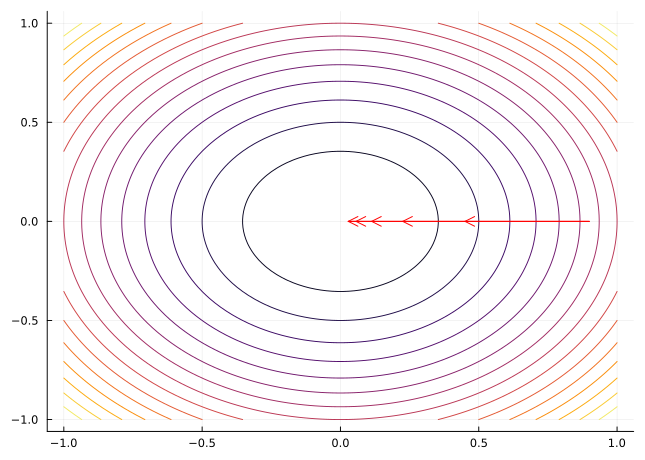

In [7]:
Lambda = [1.0, 1.0]
plt = plot_gd_steps(5,
  x_step_0, Lambda, eta)

## Contours With a Less Well Conditioned Matrices

-   Let $\Lambda = \text{diag}(1, 0.5)$
-   Does great in one direction, but slows down


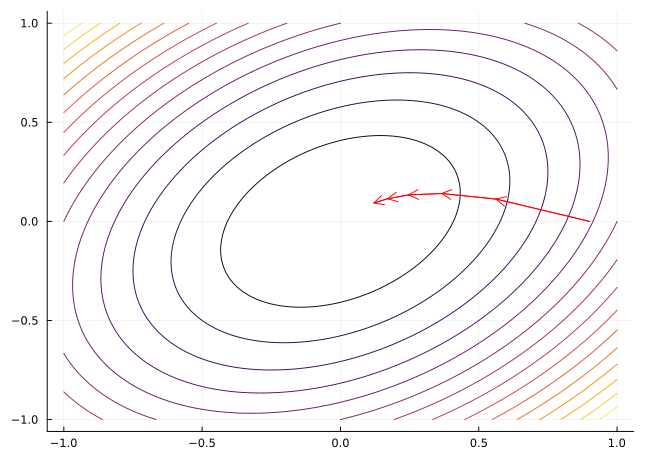

In [8]:
x_step_0 = [0.9, 0.0]
Lambda = [1.0, 0.5]
eta = 0.5
N_steps = 5
plt = plot_gd_steps(N_steps,
  x_step_0, Lambda, eta)

## Contours Getting Closer to a “Ridge”

-   Let $\Lambda = \text{diag}(1, 0.1)$


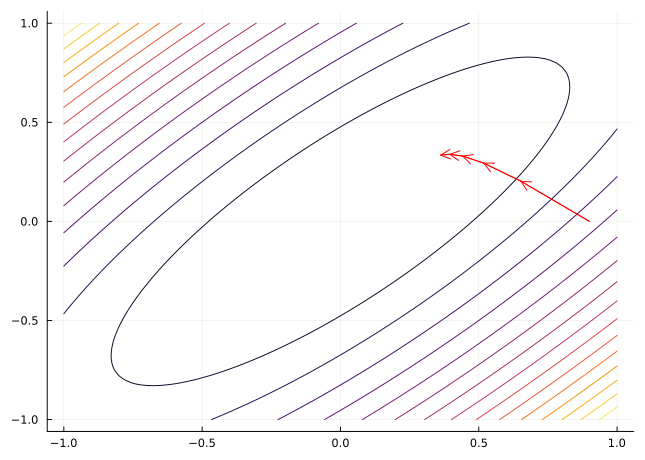

In [9]:
x_step_0 = [0.9, 0.0]
Lambda = [1.0, 0.1]
eta = 0.5
N_steps = 5
plt = plot_gd_steps(N_steps,
  x_step_0, Lambda, eta)

## Contours With Terribly Conditioned Matrices

-   Let $\Lambda = \text{diag}(1, 0.01)$
-   Can barely move in the “bad” direction


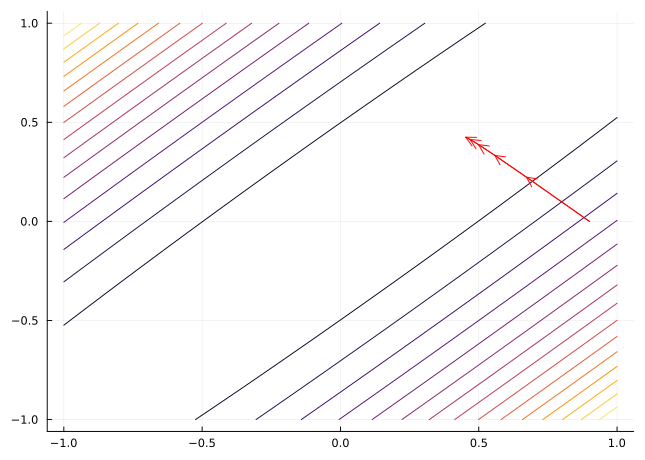

In [10]:
x_step_0 = [0.9, 0.0]
Lambda = [1.0, 0.01]
eta = 0.5
N_steps = 5
plt = plot_gd_steps(N_steps,
  x_step_0, Lambda, eta)

## Contours With Ill-Conditioned Matrices

-   Let $\Lambda = \text{diag}(1, 0.0)$
-   Not full rank, positive semi-definite. But hits minima


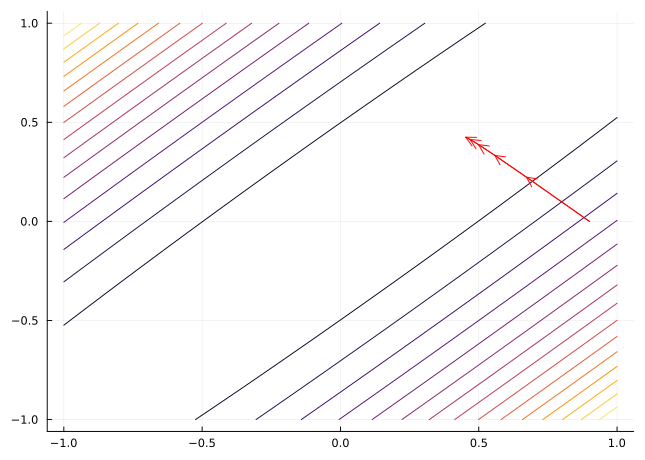

In [11]:
x_step_0 = [0.9, 0.0]
Lambda = [1.0, 0.01]
eta = 0.5
N_steps = 5
plt = plot_gd_steps(N_steps,
  x_step_0, Lambda, eta)

## Motivation for Regularization and Conditioning

-   Geometry, not dimensionality, the key to understanding a large class
    of algorithms (anything you would use in high-dimensions)
    -   “Local” geometry is summarized by the “spectrum” of the Hessian
    -   In particular, wildly mismatched eigenvalues are the enemy $$
        \text{cond}(A) = \left|\frac{\lambda_{\max}(A)}{\lambda_{\min}(A)}\right|
        $$
-   Regularization: ridge $\alpha ||x||_2^2$ then spectrum becomes
    $\lambda_i + \alpha$
-   See more in [Mark Schmidt’s Notes on Gradient
    Descent](https://www.cs.ubc.ca/~schmidtm/Courses/340-F22/L13.pdf)